## Import required Libraries


In [ ]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import math
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from pylab import rcParams
from bokeh.plotting import figure, show, output_file
from matplotlib.pylab import date2num
sns.set_style('whitegrid')
plt.style.use('default')

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Install Talib

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

--2020-06-30 14:03:00--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-06-30 14:03:00--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-06-30 14:03:00--  https://netactuate.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netactuate

### Install Mpl Finance

In [ ]:
pip install mplfinance

     |████████████████████████████████| 51kB 2.3MB/s 


Import installed libraries

In [ ]:
import talib
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num

## Dataframe Creation

In [ ]:
url = 'https://raw.githubusercontent.com/sj-leshrac/Stock_Market_Data/master/SENSEX2020_June.csv'
df1 = pd.read_csv(url)

In [ ]:
# Set Date as Index
df1['Date'] = pd.to_datetime(df1.Date)
df1.set_index("Date", inplace = True)
df=df1[['Close']].copy()
df_all=df1.copy()
df_all1= df1.copy()


In [ ]:
# Prediction dates
empty=0
begin_date = '2020-06-12'
prediction = pd.DataFrame({'empty':empty, 'Date':pd.date_range(begin_date, periods=62)})

## Descriptives & Visualizations

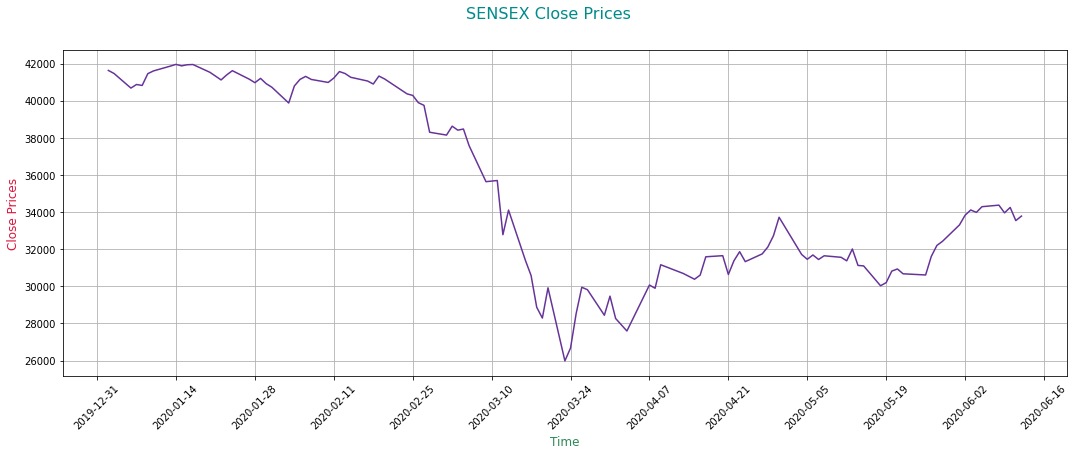

In [ ]:
# Line plot
rcParams['figure.figsize'] = 18,6
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.ylabel("Close Prices", fontsize=12, color='crimson')
plt.suptitle("SENSEX Close Prices", fontsize=16, color='darkcyan')
plt.xticks(rotation=45)
plt.grid()
ax = sns.lineplot(data=df["Close"], color="rebeccapurple")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

### Interactive Candlestick chart

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df_all.index,
                open=df_all['Open'],
                high=df_all['High'],
                low=df_all['Low'],
                close=df_all['Close'])])
fig.update_layout(
    title= {
        'text': 'SENSEX',
      'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
      font=dict(
        family="Courier New, monospace",
        size=20,
        color="#7f7f7f"
    )
    )
fig.show()

### Moving Average & RSI

In [ ]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['Close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["Close"], timeperiod=10)
    data["ma30"] = talib.MA(data["Close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["Close"])
    return data

In [ ]:
df_all2 = get_indicators(df_all1)
df_all2

,Open,High,Low,Close,Adj Close,Volume,macd,macd_signal,macd_hist,ma10,ma30,rsi
Date,,,,,,,,,,,,
2020-01-02,41340.269531,41649.289063,41328.449219,41626.640625,41626.640625,5300,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,41634.511719,41636.179688,41348.679688,41464.609375,41464.609375,8900,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,41378.339844,41378.339844,40613.960938,40676.628906,40676.628906,8700,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,40983.039063,41230.140625,40727.371094,40869.468750,40869.468750,11900,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,40574.828125,40866.359375,40476.550781,40817.738281,40817.738281,18200,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,34841.171875,34927.800781,34211.828125,34370.578125,34370.578125,25700,715.647486,354.091901,361.555586,33071.631641,32003.014258,66.856105
2020-06-09,34520.789063,34811.289063,33881.191406,33956.691406,33956.691406,19200,731.880466,429.649614,302.230852,33406.370703,32090.663281,62.528384
2020-06-10,34029.140625,34350.171875,33949.460938,34247.050781,34247.050781,15500,759.420665,495.603824,263.816841,33670.553711,32174.128971,64.275506


In [ ]:
def plot_chart(data, n, ticker):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    plt.grid()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    plt.grid()

    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    plt.grid()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    # Save the chart as PNG
    #fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    plt.grid()
    plt.show()

In [ ]:
a1=len(df_all2)-30

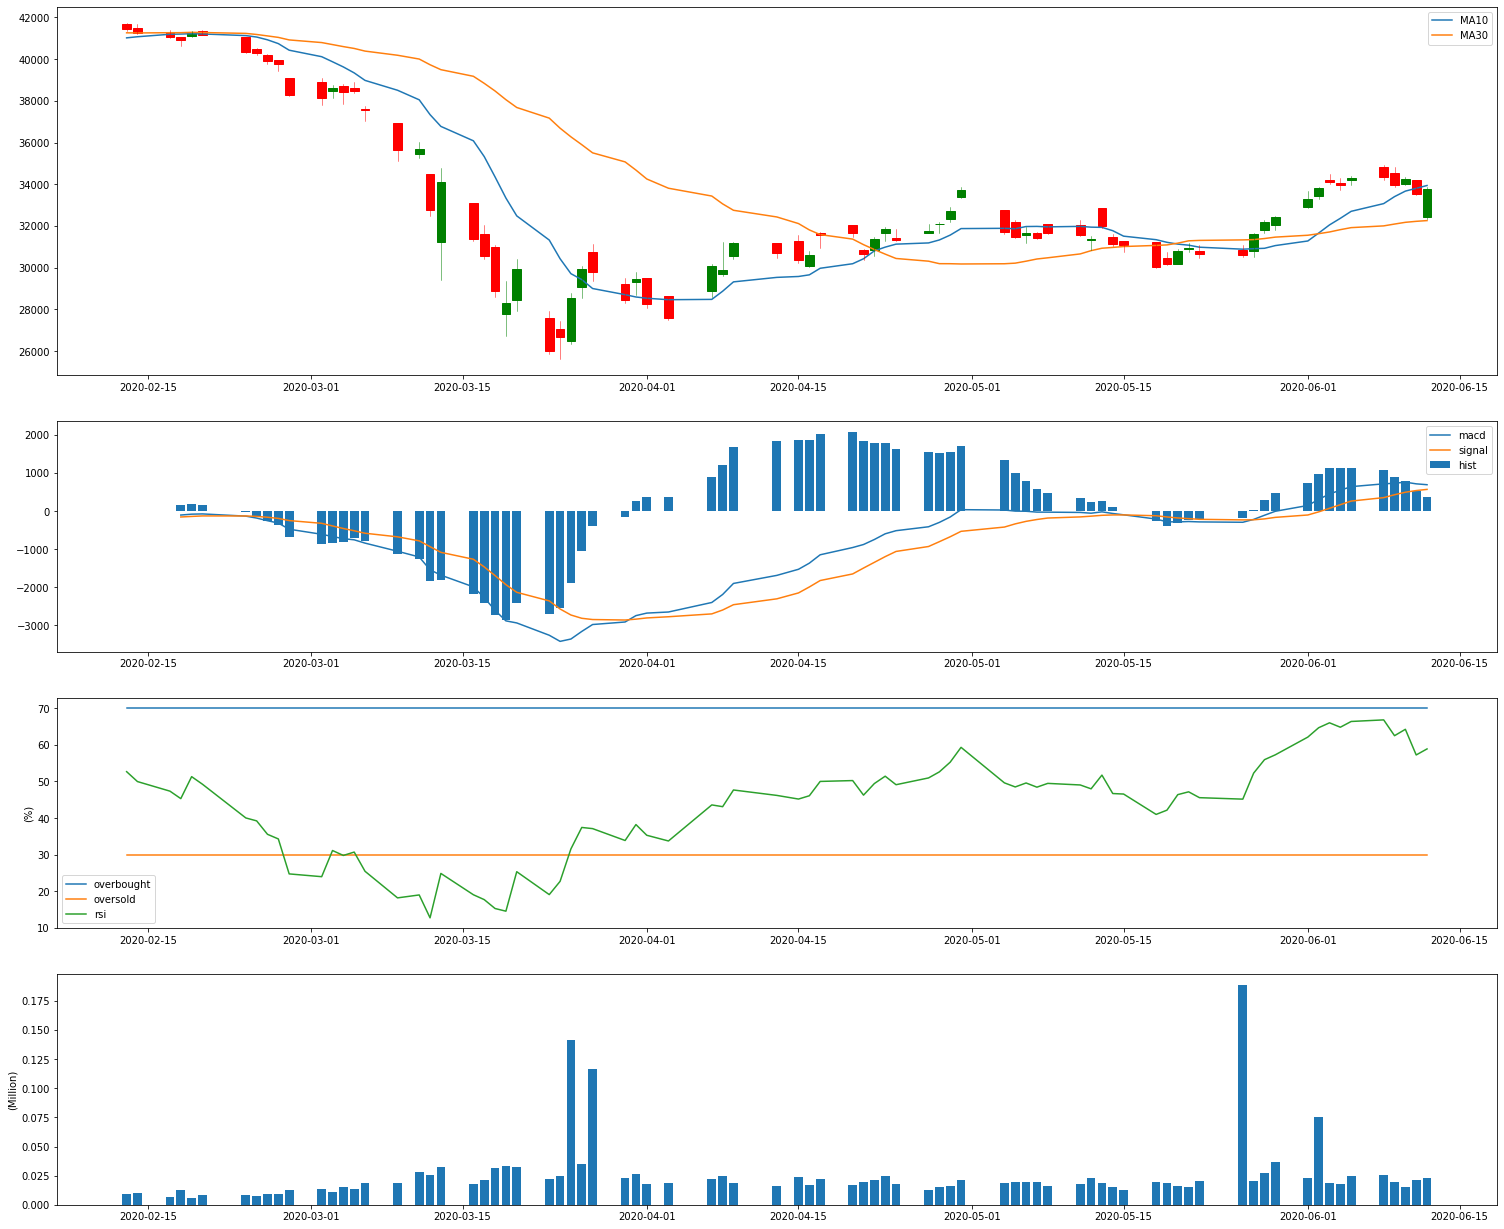

In [ ]:
plot_chart(df_all2, a1, "NIFTY")

Scatter Plot

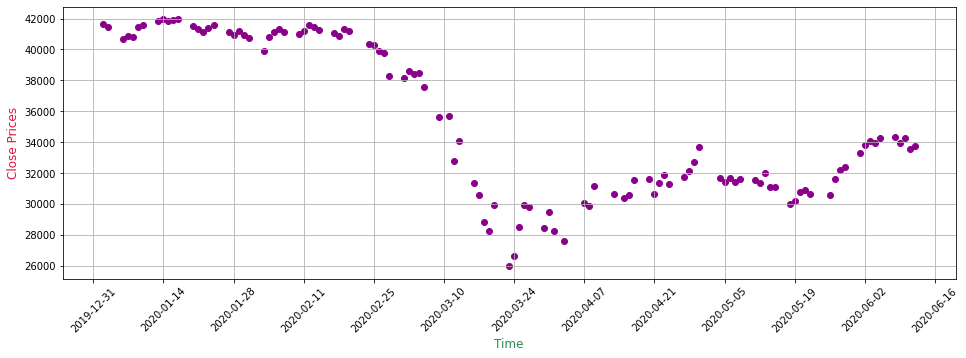

In [ ]:
rcParams['figure.figsize'] = 16, 5
fig, ax = plt.subplots()
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.ylabel("Close Prices", fontsize=12, color='crimson')
ax.scatter(x=df.index.values, y=df['Close'], color='darkmagenta')
plt.xticks(rotation=45)
plt.grid()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.show()

###Rolling Mean & trend seperation

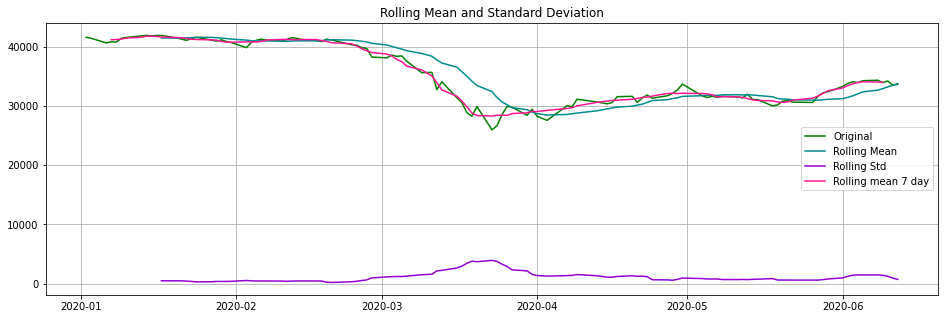

In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    rolmean_7d = timeseries.rolling(window = 7, center = True).mean()
    rolmean_365d = timeseries.rolling(window = 365, center = True).mean()
    #Plot rolling statistics:
    rcParams['figure.figsize'] = 16, 5
    plt.plot(timeseries, color='green',label='Original')
    plt.plot(rolmean, color='darkcyan', label='Rolling Mean')
    plt.plot(rolstd, color='darkviolet', label = 'Rolling Std')
    plt.plot(rolmean_7d, color='deeppink', label='Rolling mean 7 day')
    #plt.plot(rolmean_365d, color='deeppink', label='Rolling Mean 365d' )
    plt.legend(loc='best')
    plt.grid()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    
    
test_stationarity(df['Close'])

In [ ]:
df['z_data'] = (df['Close'] - df.Close.rolling(window=12).mean()) / df.Close.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

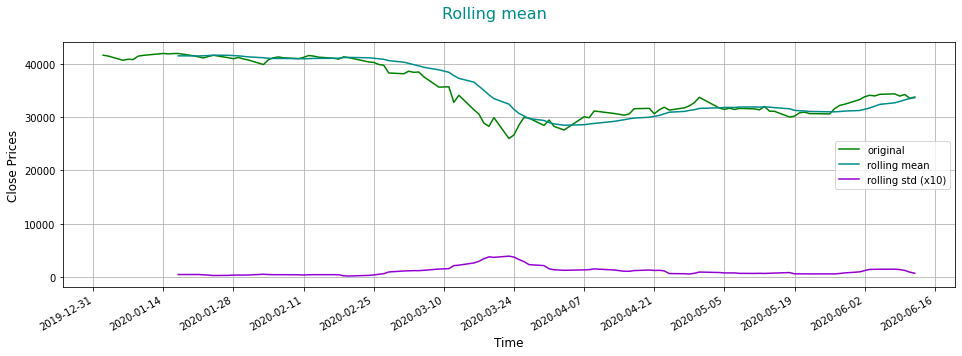

In [ ]:
rcParams['figure.figsize'] = 16, 5
fig, ax = plt.subplots()
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("Rolling mean", fontsize=16, color='darkcyan') 
ax.plot(df.index, df.Close, label='original', color='green')
ax.plot(df.Close.rolling(window=12).mean(), label="rolling mean", color='darkcyan');
ax.plot(df.Close.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet');
ax.tick_params(direction='out')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.legend(loc='best')
plt.grid()
fig.autofmt_xdate()
plt.show()

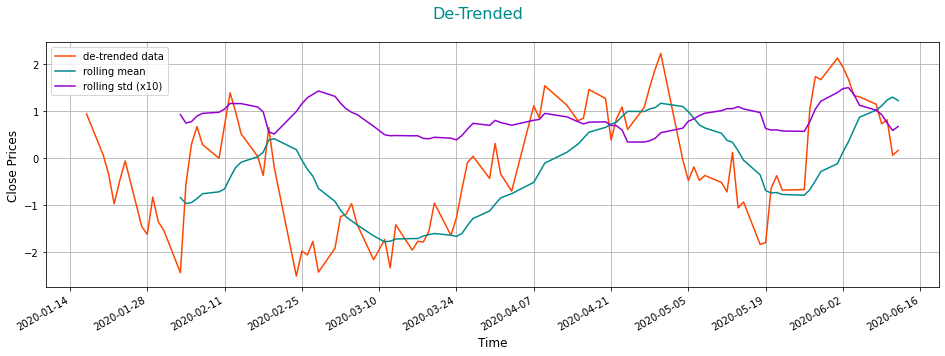

In [ ]:
rcParams['figure.figsize'] = 16, 5
fig, ax = plt.subplots()
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("De-Trended", fontsize=16, color='darkcyan') 
ax.plot(df.index, df.z_data, label="de-trended data", color='orangered')
ax.plot(df.z_data.rolling(window=12).mean(), label="rolling mean", color='darkcyan');
ax.plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet');
ax.tick_params(direction='out')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.legend(loc='best')
plt.grid()
fig.autofmt_xdate()
plt.show()

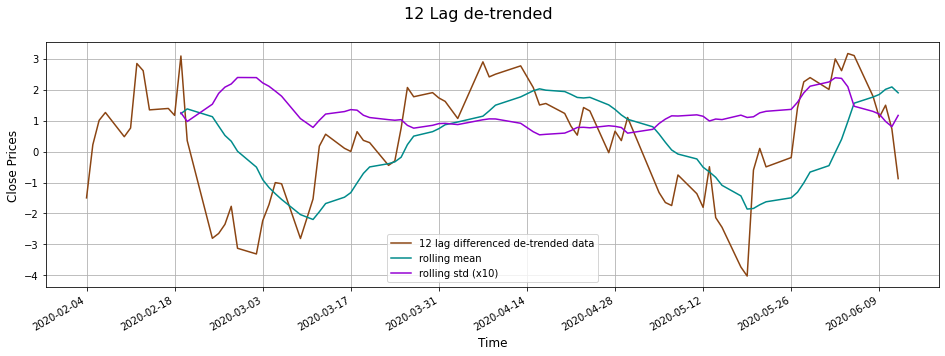

In [ ]:
rcParams['figure.figsize'] = 16, 5
fig, ax = plt.subplots()
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("12 Lag de-trended", fontsize=16) 
ax.plot(df.index, df.zp_data, label="12 lag differenced de-trended data", color='saddlebrown')
ax.plot(df.zp_data.rolling(window=12).mean(), label="rolling mean", color='darkcyan');
ax.plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet');
ax.tick_params(direction='out')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.legend(loc='best')
plt.grid()
fig.autofmt_xdate()
plt.show()

Same plots but consolidated

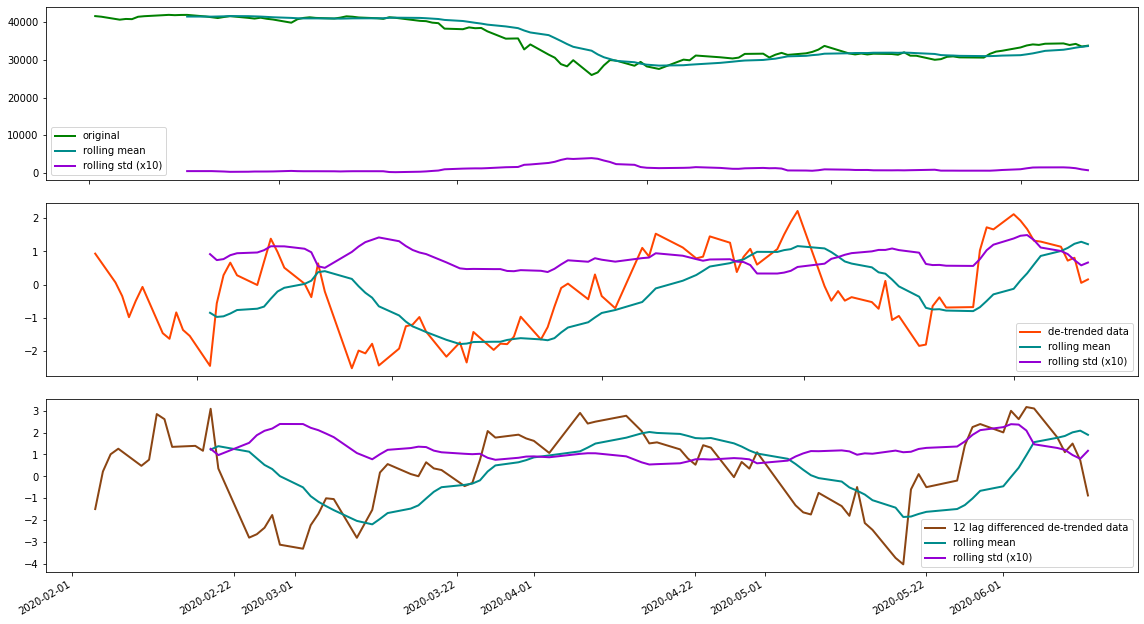

In [ ]:
fig, ax = plt.subplots(3,figsize=(16, 10))
ax[0].plot(df.index, df.Close, label='original', color='green', linewidth='2')
ax[0].plot(df.Close.rolling(window=12).mean(), label="rolling mean", color='darkcyan', linewidth='2');
ax[0].plot(df.Close.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet', linewidth='2');
ax[0].legend()

ax[1].plot(df.index, df.z_data, label="de-trended data", color='orangered', linewidth='2')
ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean", color='darkcyan', linewidth='2');
ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet', linewidth='2');
ax[1].legend()

ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data", color='saddlebrown', linewidth='2')
ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean", color='darkcyan', linewidth='2');
ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)", color='darkviolet', linewidth='2');
ax[2].legend()

plt.tight_layout()
fig.autofmt_xdate()

### Augmented Dickey-Fuller Test

In [ ]:

from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.Close, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -1.742
P-value = 0.410
Critical values :
	1%: -3.4968181663902103 - The data is not stationary with 99% confidence
	5%: -2.8906107514600103 - The data is not stationary with 95% confidence
	10%: -2.5822770483285953 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.959
P-value = 0.039
Critical values :
	1%: -3.4996365338407074 - The data is not stationary with 99% confidence
	5%: -2.8918307730370025 - The data is  stationary with 95% confidence
	10%: -2.5829283377617176 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.268
P-value = 0.183
Critical values :
	1%: -3.5232835753964475 - The data is not stationary with 99% confidence
	5%: -2.902030597326081 - The data is not stationary with 95% confidence
	10%: -2.5883710883843123 - The data is not stationary with 90% confidence


### Auto Correlation Plot

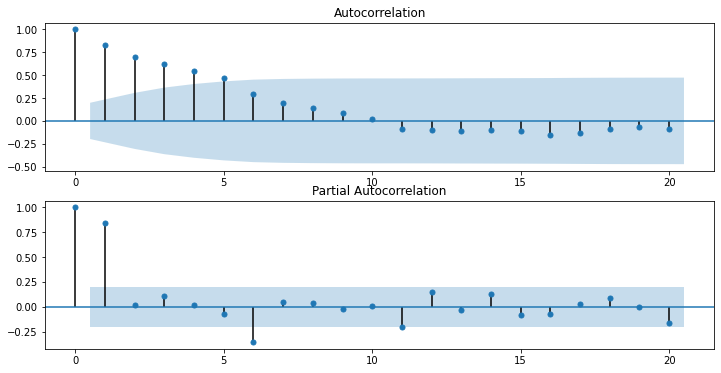

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.z_data.dropna(), ax=ax[1], lags=20)


### Seasonality Break

<Figure size 1152x360 with 0 Axes>

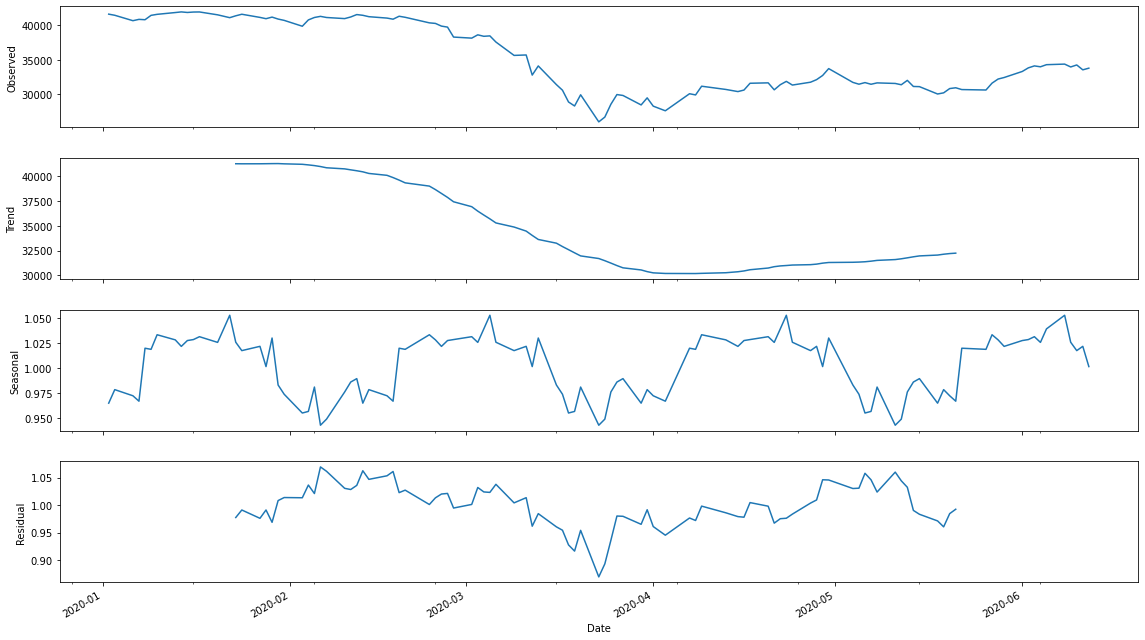

In [ ]:
# Multiplicative Seasonality
plt.style.use('fast')
mult_seasonality = seasonal_decompose(df["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  

fig = mult_seasonality.plot()
fig.set_size_inches(16, 10)


## Train-Test Split

In [ ]:
size = int(len(df)*0.8)
df_train2, df_test2 = df.iloc[:size], df.iloc[size:]

df_train1=df_train2.Close
df_train1=df_train1.to_frame()
train=df_train1.copy()

df_test1=df_test2.Close
df_test1=df_test1.to_frame()
test=df_test1.copy()

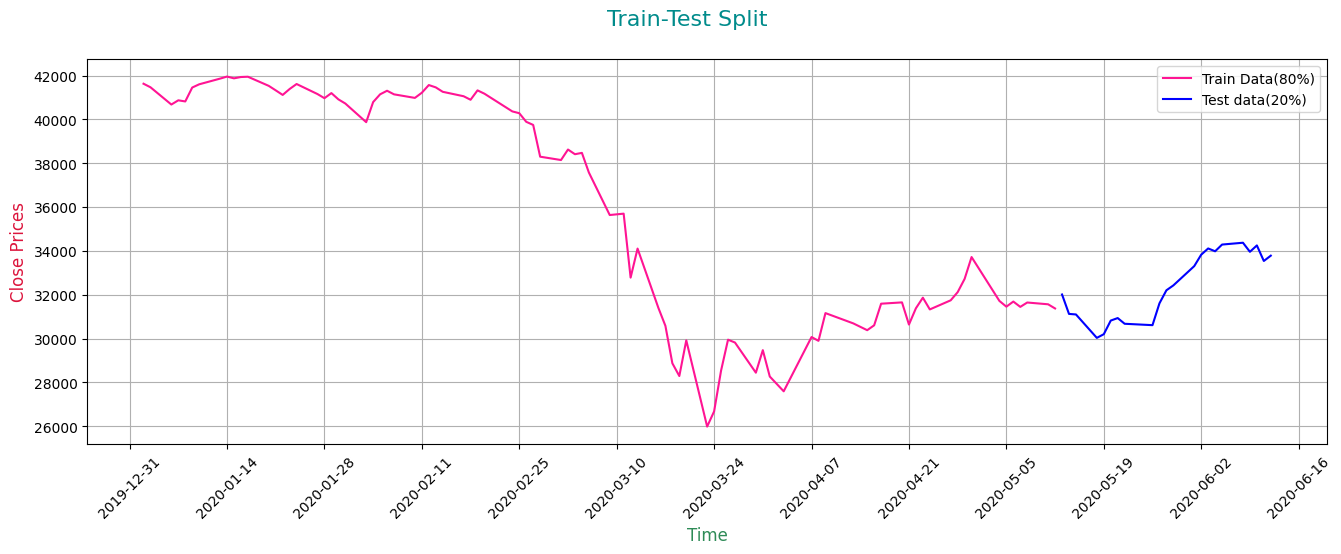

In [ ]:
plt.style.use('default')
rcParams['figure.figsize'] = 16,5
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.ylabel("Close Prices", fontsize=12, color='crimson')
plt.suptitle("Train-Test Split", fontsize=16, color='darkcyan')
plt.xticks(rotation=45)
plt.grid()
plt.style.use('default')
ax = sns.lineplot(data=train["Close"], color="deeppink", label='Train Data(80%)')
ax = sns.lineplot(data=test["Close"], color="blue", label='Test data(20%)')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

## Analysis

### Simple Exponential Smoothing

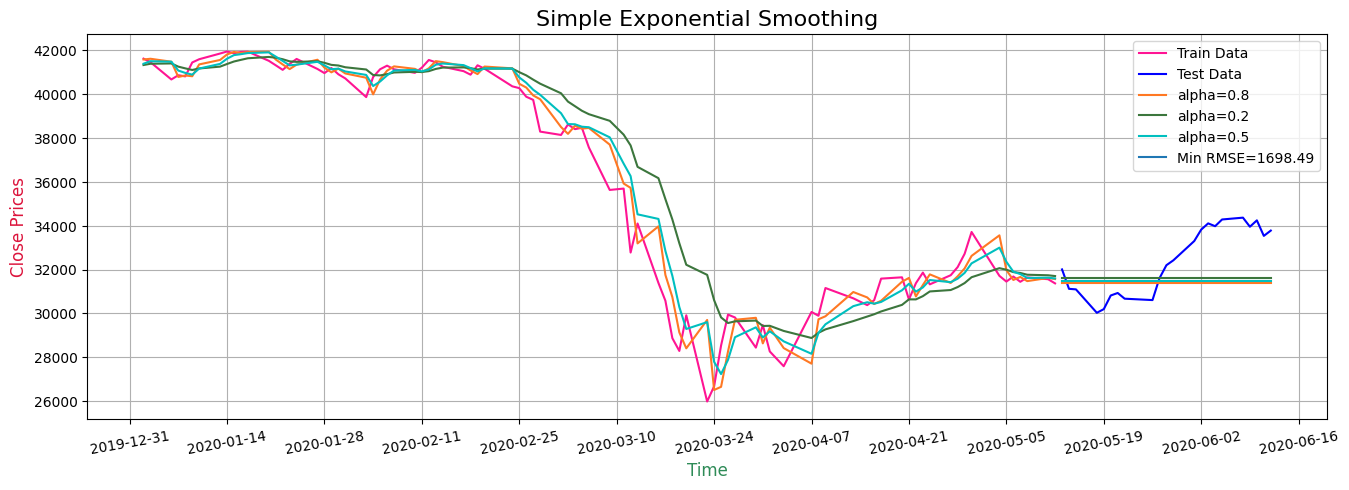

In [ ]:
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['Close']))


fit1 = model.fit()
pred1 = fit1.forecast(len(test))
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(len(test))
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(len(test))


rmse1 = np.sqrt(np.mean(np.square(pred.values - pred1)))
rmse2 = np.sqrt(np.mean(np.square(pred.values - pred2)))
rmse3 = np.sqrt(np.mean(np.square(pred.values - pred3)))
rmse_ses=min(rmse1, rmse2, rmse3)

fig, ax = plt.subplots(figsize=(16, 5))
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.ylabel("Close Prices", fontsize=12, color='crimson')
plt.xticks(rotation=10)

ax.plot(train.index, train.values, color='deeppink', label='Train Data')
ax.plot(test.index, test.values, color="blue", label='Test Data')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2)) 
plt.plot([], [], '', label="Min RMSE={:0.2f}".format(rmse_ses))   
plt.title("Simple Exponential Smoothing",fontsize=16)  
plt.grid()
plt.legend()
plt.show()  


### Damped Exponential Smoothing

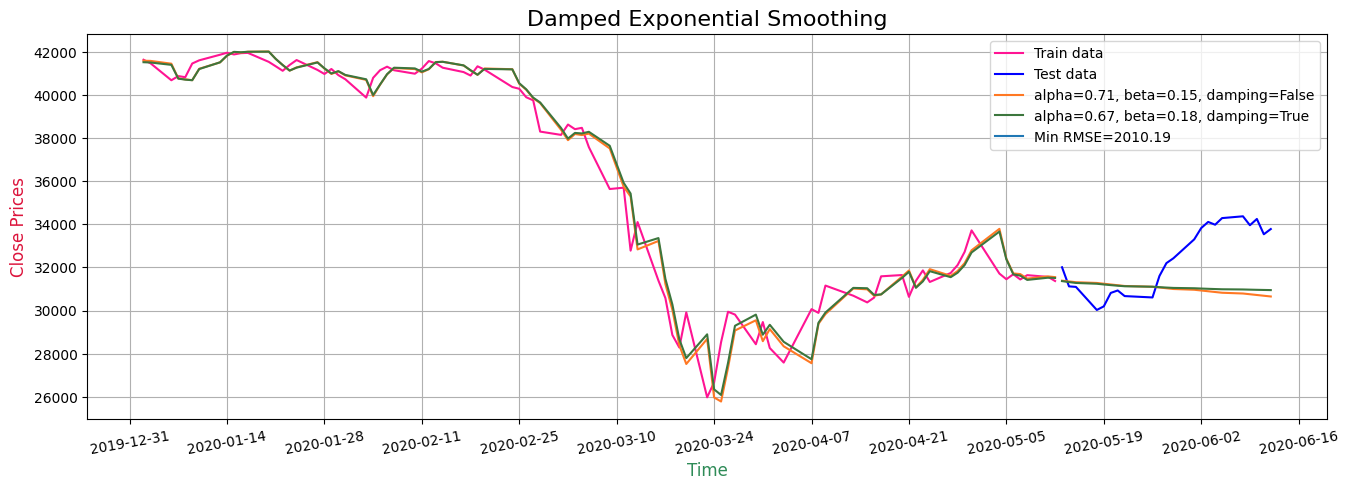

In [ ]:

model = ExponentialSmoothing(np.asarray(train['Close']), trend='mul', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['Close']), trend='mul', seasonal=None, damped=True)


fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(len(test))
pred2 = fit2.forecast(len(test))

rmse4 = np.sqrt(np.mean(np.square(pred.values - pred1)))
rmse5 = np.sqrt(np.mean(np.square(pred.values - pred2)))
rmse_des=min(rmse4, rmse5)

fig, ax = plt.subplots(figsize=(16, 5))
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.ylabel("Close Prices", fontsize=12, color='crimson')
plt.xticks(rotation=10)
ax.plot(train.index, train.values, color="deeppink", label="Train data")
ax.plot(test.index, test.values, color="blue", label="Test data")

for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False), color=c)
    
ax.set_title("Damped Exponential Smoothing",fontsize=16);
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.plot([], [], '', label="Min RMSE={:0.2f}".format(rmse_des))
plt.grid()
plt.legend();


### Holt's Exponential Smoothing

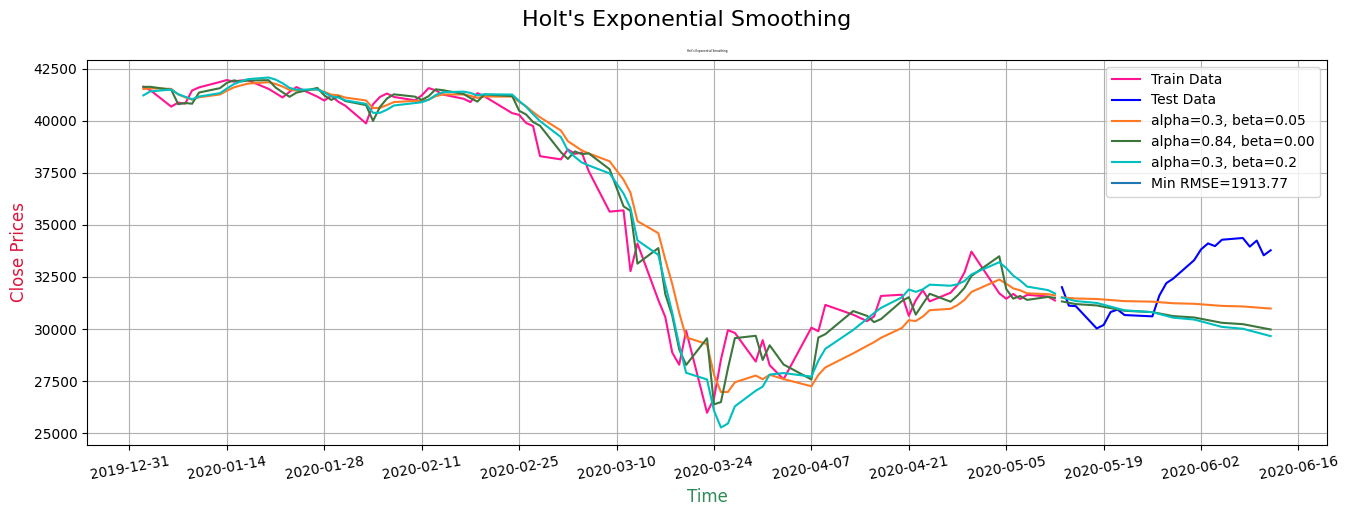

In [ ]:
model = Holt(np.asarray(train['Close']))


fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(len(test))
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test))
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(len(test))

rmse6 = np.sqrt(np.mean(np.square(pred.values - pred1)))
rmse7 = np.sqrt(np.mean(np.square(pred.values - pred2)))
rmse8 = np.sqrt(np.mean(np.square(pred.values - pred3)))
rmse_hes=min(rmse6, rmse7, rmse7)

fig, ax = plt.subplots(figsize=(16, 5))
plt.xlabel("Time",fontsize=12, color='seagreen')
plt.suptitle("Holt's Exponential Smoothing", fontsize=16) 
plt.ylabel("Close Prices", fontsize=12, color='crimson')
plt.xticks(rotation=10)
ax.plot(train.index, train.values, color='deeppink', label='Train Data')
ax.plot(test.index, test.values, color="blue", label='Test Data')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.plot([], [], '', label="Min RMSE={:0.2f}".format(rmse_hes))
plt.title("Holt's Exponential Smoothing",fontsize=2)
plt.grid()
plt.legend();


### Trend regression

<Figure size 640x480 with 0 Axes>

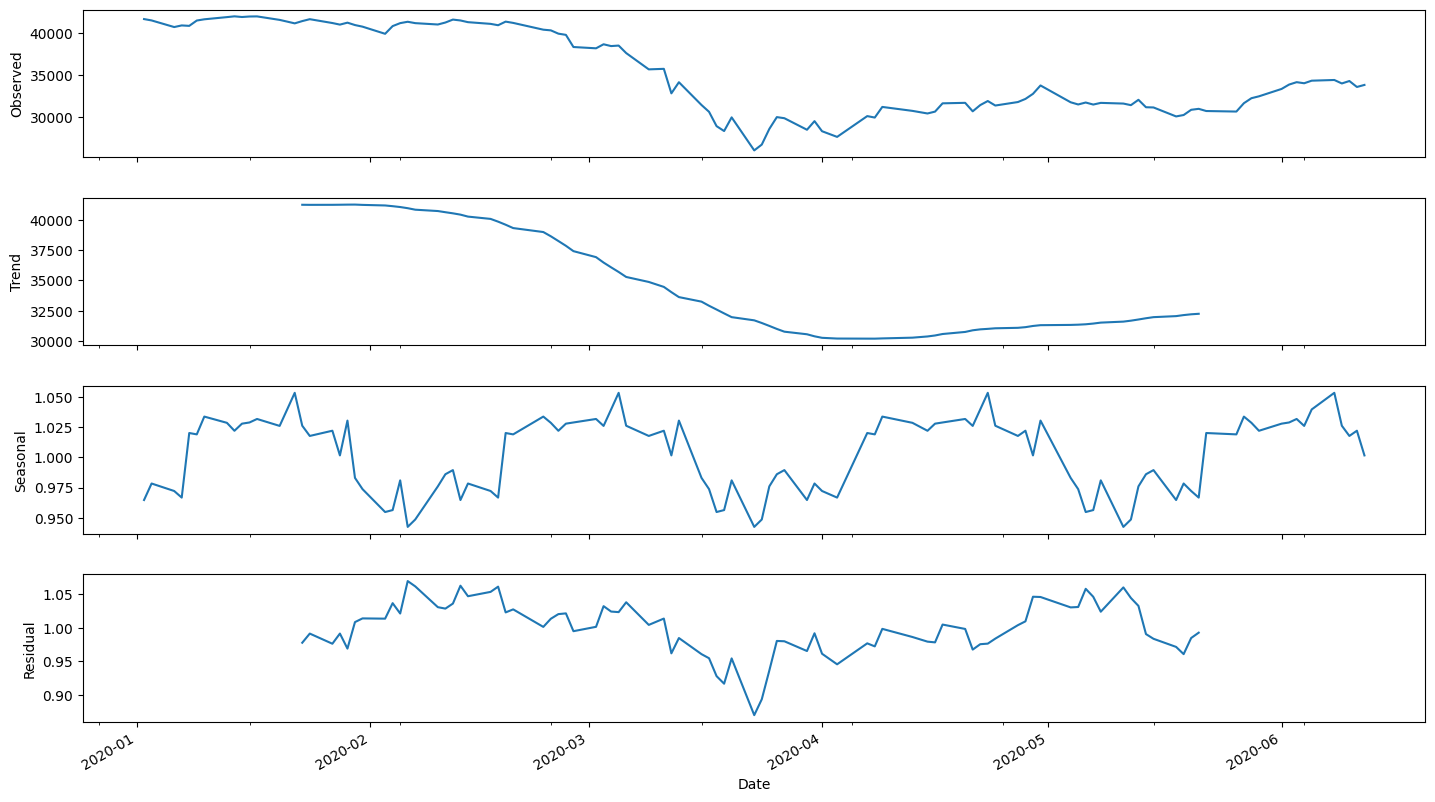

In [ ]:
# Multiplicative Seasonality
mult_seasonality = seasonal_decompose(df["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = mult_seasonality.plot() 
fig.set_size_inches(16, 9)

In [ ]:
import statsmodels.api as sm
from statsmodels.api import OLS

x, y = np.arange(len(mult_seasonality.trend.dropna())), mult_seasonality.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())




                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     277.5
Date:                Tue, 30 Jun 2020   Prob (F-statistic):           3.02e-27
Time:                        14:06:23   Log-Likelihood:                -710.84
No. Observations:                  79   AIC:                             1426.
Df Residuals:                      77   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.105e+04    441.782     92.914      0.0

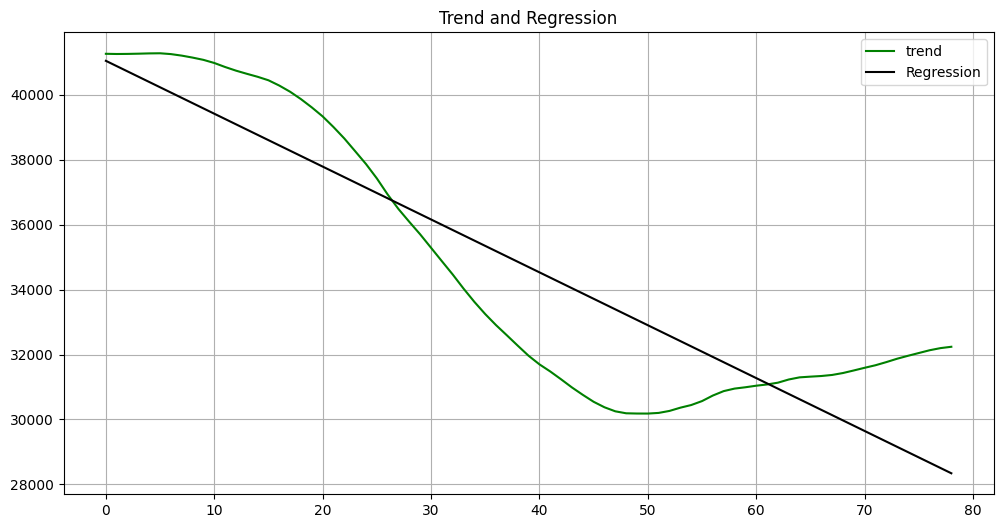

In [ ]:
fig, ax = plt.subplots(figsize=(12,6));
ax.plot(mult_seasonality.trend.dropna().values, color='Green',label='trend')
ax.plot([res.params.x1*i + res.params.const for i in np.arange(len(mult_seasonality.trend.dropna()))], color='Black', label='Regression')
ax.set_title("Trend and Regression")
plt.legend()
plt.grid()
plt.show()

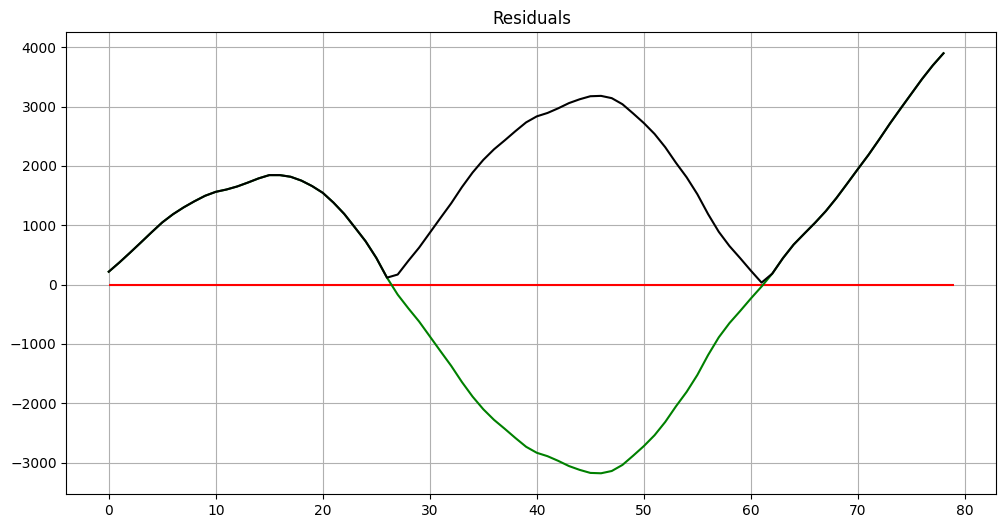

In [ ]:
fig, ax = plt.subplots(figsize=(12,6));
ax.plot(res.resid.values, color='Green')
ax.plot(np.abs(res.resid.values), color='Black')
ax.hlines(0, 0, len(res.resid), color='r')
ax.set_title("Residuals")
plt.grid()
plt.show()

### Holt's Winter Seasonal Smoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be g

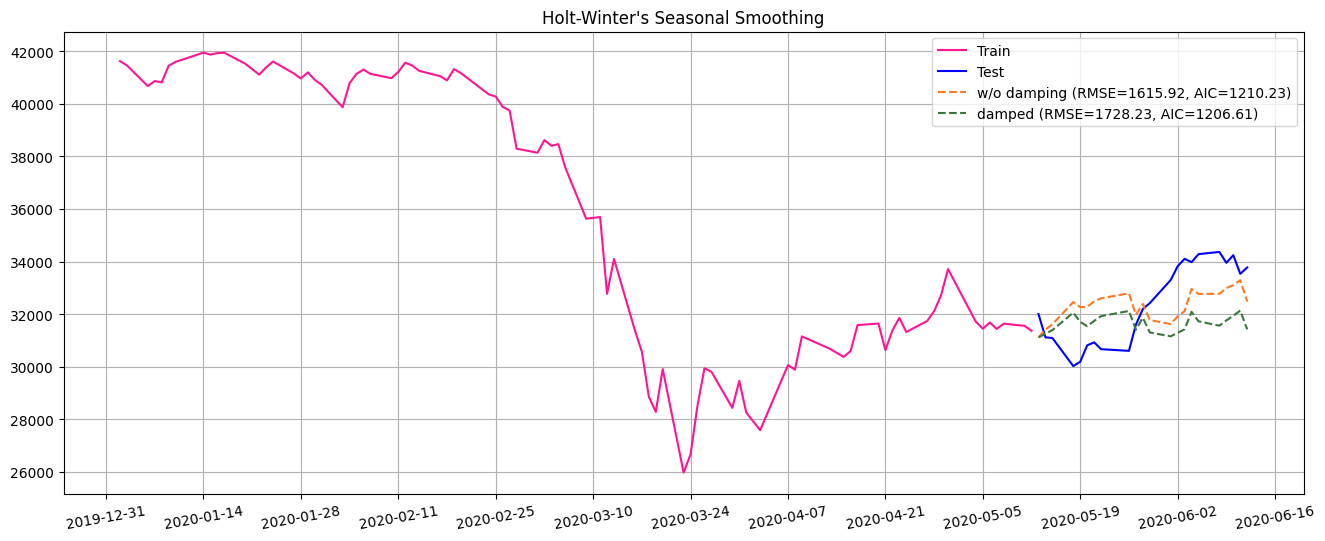

In [ ]:

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
future1=fit.forecast(62+len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))
future2=fit2.forecast(62+len(test))

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
rmse_hwss= min(sse1, sse2)


fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train.index, train.values, label='Train', color='deeppink');
ax.plot(test.index, test.values, label='Test', color='blue');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2));
plt.xticks(rotation=10);
plt.grid()
ax.set_title("Holt-Winter's Seasonal Smoothing");


## Predictions

In [ ]:
ft1= pd.DataFrame(future1, columns=['prediction']).set_index('prediction')
ft2= pd.DataFrame(future2, columns=['prediction']).set_index('prediction')
ft1= ft1.iloc[(len(test)):]
ft2= ft2.iloc[(len(test)):]

### Prediction by Holt-Winter's Exp Smoothing

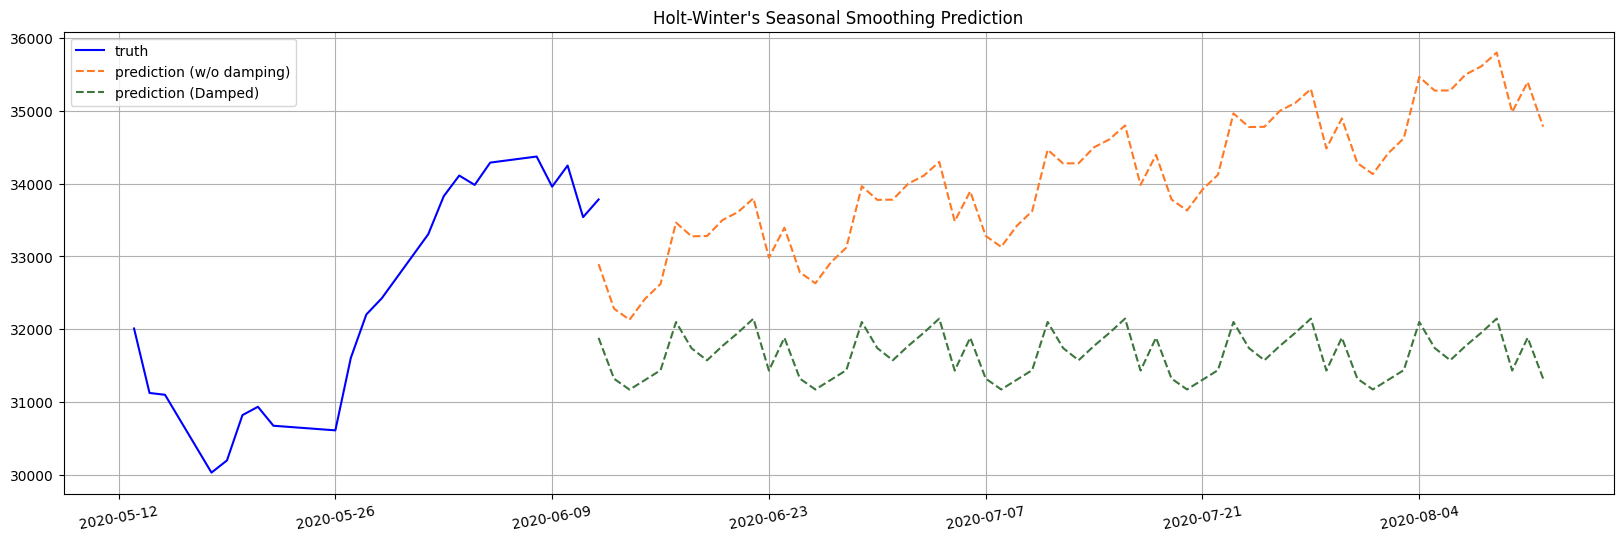

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
#ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='truth', color='blue');
#ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
#ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.plot(prediction.Date, ft1.index, linestyle='--', color='#ff7823', label='prediction (w/o damping)');
ax.plot(prediction.Date, ft2.index, linestyle='--', color='#3c763d', label='prediction (Damped)'); 
ax.legend();
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2));
plt.xticks(rotation=10);
plt.grid()
ax.set_title("Holt-Winter's Seasonal Smoothing Prediction");

## Model Comparison

### RMSE Comparison

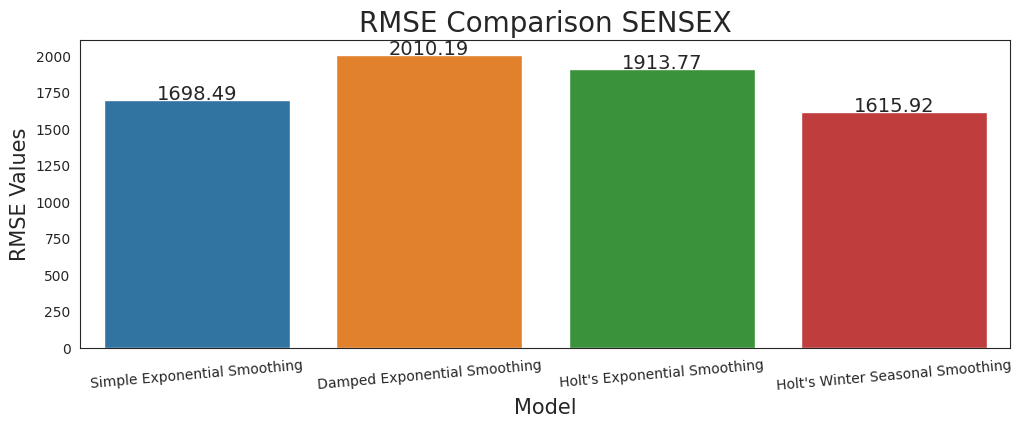

In [ ]:
# combine all models' results into one dataframe
data = {"Model": ["Simple Exponential Smoothing", "Damped Exponential Smoothing", "Holt's Exponential Smoothing", "Holt's Winter Seasonal Smoothing"], 
        "RMSE": [rmse_ses, rmse_des, rmse_hes, rmse_hwss]}

results = pd.DataFrame(data=data)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.barplot(x="Model", y="RMSE", data=results)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+1, "{:1.2f}".format(height), ha="center", fontsize=14) 
plt.title('RMSE Comparison SENSEX', size=20)
plt.xlabel('Model', size=15)
plt.ylabel('RMSE Values', size=15)
plt.xticks(rotation=5)
plt.show(fig)
